In [1]:
import json
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import ternary
%matplotlib inline

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [2]:
# Class to store each tag coordinate data
class tagClass:
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [3]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [4]:
def getTags(rawData, nType):
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [5]:
trainTags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
testTags = getTags(raw15['0'], ['669', '671'])

In [6]:
bayerFilter = [["R", "G"],
               ["G", "B"]]
# Find Bayer filter pixel colour for given coordinate
def getBayer(x, y):
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [7]:
def getSnipPlot(tag):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    plt.imshow(photo[tagY:tagY2,tagX:tagX2],cmap='gray')
    plt.colorbar()
    # rect = patches.Rectangle((tag.getY()-tagY-5, tag.getX()-tagX-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    return photo[tagY:tagY2,tagX:tagX2]

In [8]:
def getPhoto(tag: tagClass):
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [9]:
def getPixels(t, photo):
    tagX, tagX2, tagY, tagY2 = t
    colourPixels = [[], [], []] # R G B
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                colourPixels[0].append(photo[py, px])
            elif col == 'G':
                colourPixels[1].append(photo[py, px])
            else:
                colourPixels[2].append(photo[py, px])
    totalSum = sum(colourPixels[0]) + sum(colourPixels[1]) + sum(colourPixels[2])
    return sum(colourPixels[0])/totalSum, sum(colourPixels[1])/totalSum, sum(colourPixels[2])/totalSum

In [10]:
xTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in trainTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    xTags.loc[len(xTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

xTrain, xTest, yTrain, yTest = train_test_split(xTags[["Red", "Green", "Blue"]], xTags["Label"], test_size=0.2)

In [11]:
yTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in testTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    yTags.loc[len(yTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

In [12]:
allTags = pd.concat([xTags, yTags])

array([[ 11,   2,  12,   3,  14,   3,  13,   3,  12,   2,  12,   3,  12,
          2,  12,   3],
       [  2,   4,   3,   4,   3,   4,   3,   4,   3,   4,   3,   4,   2,
          3,   2,   4],
       [ 11,   3,  12,   3,  13,   3,  12,   3,  11,   3,  11,   2,  11,
          2,  10,   2],
       [  2,   3,   3,   5,   3,   4,   3,   4,   2,   3,   3,   5,   3,
          4,   3,   3],
       [ 11,   3,  12,   3,  11,   3,  11,   4,  15,   4,  12,   3,  11,
          3,   9,   3],
       [  2,   4,   3,   5,   3,   4,   3,  17,   9,  21,   7,   7,   5,
          6,   5,   8],
       [  8,   2,  10,   2,  11,   3,  20,  16,  83,  26,  54,  11,  19,
          8,  16,  10],
       [  2,   3,   2,   4,   3,  10,  13,  57,  27,  65,  28,  26,  10,
         12,   9,  14],
       [  8,   2,  10,   2,   9,   5,  37,  28, 102,  36, 102,  22,  24,
         10,  19,  10],
       [  1,   3,   2,   3,   3,  12,  13,  59,  33,  72,  35,  41,  11,
         12,   9,  11],
       [  7,   1,   9,   2,  1

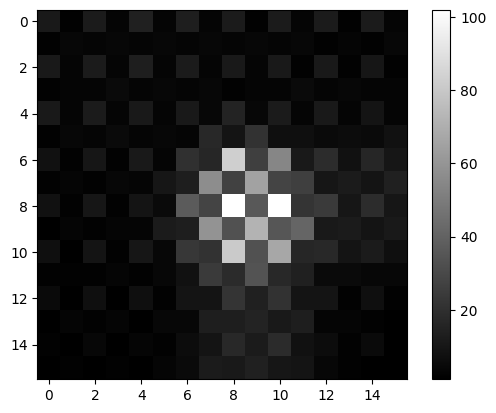

In [13]:
getSnipPlot(xTags["Tag"][0])

## Plot to RGB heatmap

In [14]:
def colorPoint(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

def plotHeatmap(asTuples, labels, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)#np.array(expected['002']))
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    plt.show()

In [15]:
scale = 30
# tagList = [0]
# sampleTags = allTags.loc[allTags["Label"].isin(tagList)]
# asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in sampleTags.iterrows()]
# labels = sampleTags["Label"]
# plotHeatmap(asTuples, labels, scale)

c:\Users\katie\AppData\Local\Programs\Python\Python311\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


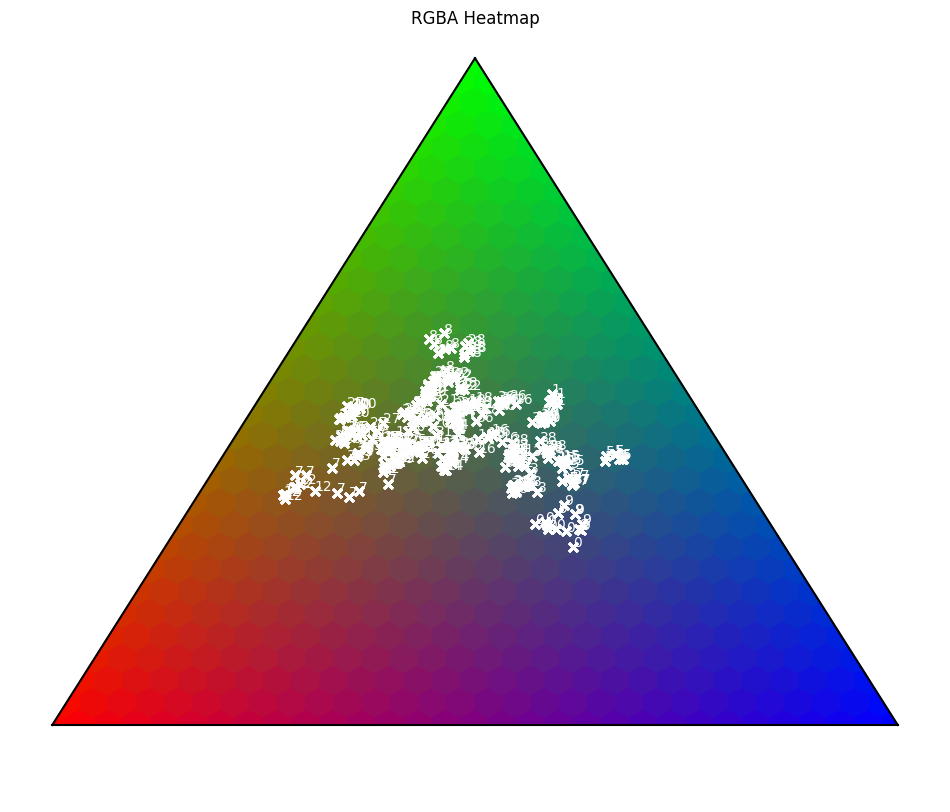

In [16]:
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in allTags.iterrows()]
labels = allTags["Label"]
plotHeatmap(asTuples, labels, scale)

## ML train/test

In [17]:
gnb = GaussianNB().fit(xTrain, yTrain)
gnbPred = gnb.predict(yTags[["Red", "Green", "Blue"]])

In [18]:
clf = svm.SVC().fit(xTrain, yTrain)
svmPred = clf.predict(yTags[["Red", "Green", "Blue"]])

In [19]:
# mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1).fit(xTrain, yTrain)
# mlpPred = mlp.predict(yTags[["Red", "Green"]])

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, name):
    print(name)
    print("Accuracy: ", accuracy_score(yTags["Label"], modelPred))
    print("F1: ", f1_score(yTags["Label"], modelPred, average='macro'))
    print("Precision: ", precision_score(yTags["Label"], modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(yTags["Label"], modelPred, average='macro'))
    print("MSE: ", mean_squared_error(yTags["Label"], modelPred), "\n")

In [21]:
scores(gnbPred, "GNB")
scores(svmPred, "SVM")
# scores(mlpPred, "MLP")

GNB
Accuracy:  0.5125
F1:  0.4692857142857143
Precision:  0.5542857142857143
Recall:  0.5125
MSE:  142.075 

SVM
Accuracy:  0.35
F1:  0.2494155844155844
Precision:  0.46929824561403505
Recall:  0.35
MSE:  177.0 



## Random notes

In [22]:
# average colours from all images - normalise
# R/(R+G+B) G/(R+G+B)
# train model on colours & labels
# test model to classfiy other image labels

# maybe remove background mesh
# func pixel coords generated to show brightness
# psf tagxy brightness pf col, bg of col, pixel ->> pred cixel col -> SSE
# brightness for each col -> then loop all pixels then predict pixels -> SSE = func - true picel val

In [23]:
# run with smaller box around pixels - brightest as centre?
# bokeh out of focus width affected by distance?
# estimate brightness of bg?
# estimate width of brightest tags
# hexagonal bokeh - find centre of bokeh
# px, py, bi, hi, xi, yi per picture but width is same
# x y is centre of bokeh - tag coords
# 
# sum ( fn(px py xi yi hi w) - true px py ) ^2 ) for each pixel -> fn = guess pixel value
# sum that for all pictures - see notebook!!

## Cost function

In [24]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    dist = math.dist(tagCoord, pixelCoord)
    if dist>psfWidth+0.5:
           return bgBrightness
    elif dist<psfWidth-0.5:
        return tagBrightness
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))
# dist>w+0.5 -> bg
# dist<w-0.5 -> tag
# bg*(0.5 + dist - w)- tag*(dist - w - 0.5) ### check func for linear transition between bg and tag

#hessian = second derivative -> hess_inv shows variance of gaussian spread
# mcmc for distribution sampling


# def simulate_image(tagCoord, [tagBright_r, tagBright_g, tagBright_b], [bgBright_r, bgBright_g, bgBright_b], psfWidth, trueImg):
def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    pixel_value_guesses = []

    # loop over pixel coords for each colour...

    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # call simulate_pixel with the coords of the pixel and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord, t[colour], b[colour], psfWidth))
    return pixel_value_guesses


def cost_function(params, psfWidth, trueImg):
    tagCoord = [params[0], params[1]]
    tagBright = [params[2], params[3], params[4]]
    bgBright = [params[5], params[6], params[7]]
    # tagBright = params[2]
    # bgBright = params[3]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, psfWidth, trueImg.shape)
    # sum square error over all the pxiels between the true image and the simulate_image
    square_error = np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses, trueImg.flatten())])
    print(square_error, params)
    return square_error

In [25]:
np.set_printoptions(precision=1)

69445.90332008121 [ 0  0 12 14  5  4  6  5]


69445.90332008121

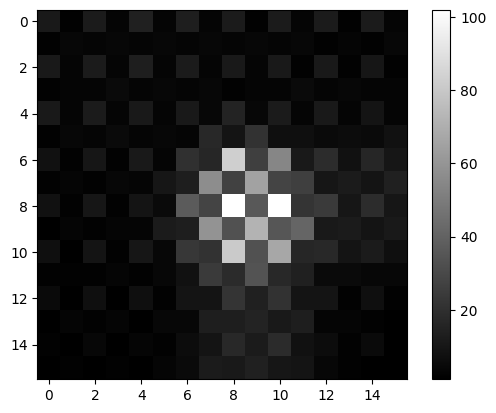

In [26]:
realImg = getSnipPlot(allTags['Tag'].iloc[0]) # clip this photo per tag
cost_function(np.array([0, 0, 12, 14, 5, 4, 6, 5]), 3, realImg)

In [29]:
initial_parameters = np.array([
    np.random.rand()*realImg.shape[0],
    np.random.rand()*realImg.shape[1], # tag location
    np.random.rand()*np.max(realImg), # intensity r
    np.random.rand()*np.max(realImg), # intensity g
    np.random.rand()*np.max(realImg), # intensity b
    np.random.rand()*np.min(realImg), # background r
    np.random.rand()*np.min(realImg), # background g
    np.random.rand()*np.min(realImg) # background b
])

initial_parameters = np.array([8,9,100,100,100,0,0,0])
res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'Nelder-Mead', bounds=[(6,10),(7,11),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
# tag loc = middle (width/2), bg = 0,  intensity = largest val in pic method='Nelder-Mead',

93668.4247128258 [  8.   9. 100. 100. 100.   0.   0.   0.]
99614.81853061746 [  8.4   9.  100.  100.  100.    0.    0.    0. ]
107174.92614411633 [  8.    9.5 100.  100.  100.    0.    0.    0. ]
95135.9247128258 [  8.   9. 105. 100. 100.   0.   0.   0.]
102237.05400574773 [  8.   9. 100. 105. 100.   0.   0.   0.]
96855.9247128258 [  8.   9. 100. 100. 105.   0.   0.   0.]
93668.11596635706 [8.0e+00 9.0e+00 1.0e+02 1.0e+02 1.0e+02 2.5e-04 0.0e+00 0.0e+00]
93668.31033742033 [8.0e+00 9.0e+00 1.0e+02 1.0e+02 1.0e+02 0.0e+00 2.5e-04 0.0e+00]
93668.25946635705 [8.0e+00 9.0e+00 1.0e+02 1.0e+02 1.0e+02 0.0e+00 0.0e+00 2.5e-04]
102375.0222543511 [8.1e+00 8.5e+00 1.0e+02 1.0e+02 1.0e+02 6.3e-05 6.3e-05 6.3e-05]
97576.03592630573 [8.1e+00 8.8e+00 1.0e+02 1.0e+02 1.0e+02 4.7e-05 4.7e-05 4.7e-05]
87218.43042543411 [8.1e+00 8.9e+00 1.0e+02 9.5e+01 1.0e+02 7.4e-05 7.4e-05 7.4e-05]
80931.67102809121 [8.2e+00 8.9e+00 1.0e+02 9.0e+01 1.0e+02 1.1e-04 1.1e-04 1.1e-04]
101354.95826519074 [7.7e+00 8.9e+00 1

In [30]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [41]:
params_test = [8, 6.5, 100, 100, 100, 0, 0, 0]
print(cost_function(params_test, 3, realImg))
tagCoord = [params_test[0], params_test[1]]
tagBright = [params_test[2], params_test[3], params_test[4]]
bgBright = [params_test[5], params_test[6], params_test[7]]

pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, 3, realImg.shape)

175565.15853169293 [8, 6.5, 100, 100, 100, 0, 0, 0]
175565.15853169293


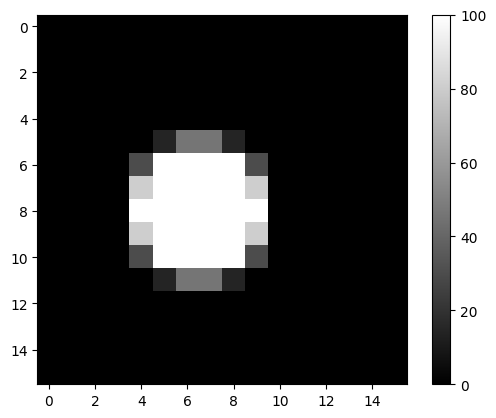

In [42]:
plt.imshow(np.array(pixel_value_guesses).reshape(16,16),cmap='gray')
plt.colorbar()


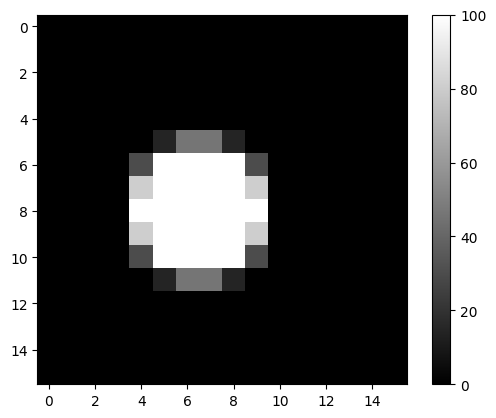

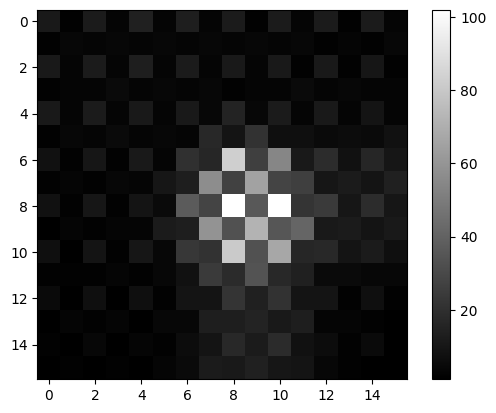

In [43]:
plt.imshow(np.array(pixel_value_guesses).reshape(16,16),cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(realImg,cmap='gray')
plt.colorbar()

In [31]:
bestScore = np.inf
best = None
for restart in range(100):
    initial_parameters = np.array([
        np.random.rand()*realImg.shape[0],
        np.random.rand()*realImg.shape[1], # tag location
        # 100, 100, 100, 0, 0, 0
        np.random.rand()*np.max(realImg), # intensity r
        np.random.rand()*np.max(realImg), # intensity g
        np.random.rand()*np.max(realImg), # intensity b
        np.random.rand()*np.min(realImg), # background r
        np.random.rand()*np.min(realImg), # background g
        np.random.rand()*np.min(realImg) # background b
    ])
    res = minimize(cost_function, initial_parameters, args = (3, realImg))
    if res.fun < bestScore:
        bestScore = res.fun
        best = res
res = best

154787.70992613572 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70946360042 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70977565757 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70993904438 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70994832902 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70992950362 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70989737305 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.70990795098 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
154787.7099090622 [4.6e+00 6.2e+00 8.9e+01 6.6e+01 3.6e+01 5.0e-02 3.0e-01 3.1e-01]
129836.77346554733 [ 5.5  6.5 89.1 66.1 35.9  0.1  0.3  0.3]
129836.77324857595 [ 5.5  6.5 89.1 66.1 35.9  0.1  0.3  0.3]
129836.77277414083 [ 5.5  6.5 89.1 66.1 35.9  0.1  0.3  0.3]
129836.77347526146 [ 5.5  6.5 89.1 66.1 35.9  0.1  0.

In [32]:
print(res)

      fun: 6686.08603213511
 hess_inv: array([[ 3.2e-05,  7.2e-06,  6.8e-04, -2.3e-05, -2.7e-04, -7.4e-05,
         6.5e-05, -6.5e-05],
       [ 7.2e-06,  2.5e-05,  3.5e-04, -2.6e-05, -1.9e-04, -1.4e-05,
         3.7e-05, -3.9e-05],
       [ 6.8e-04,  3.5e-04,  9.2e-02, -1.3e-04, -7.5e-03, -1.6e-03,
         4.4e-04, -1.6e-03],
       [-2.3e-05, -2.6e-05, -1.3e-04,  2.2e-03,  7.1e-04,  4.4e-04,
        -2.1e-03, -1.3e-05],
       [-2.7e-04, -1.9e-04, -7.5e-03,  7.1e-04,  7.6e-02, -6.1e-04,
        -1.4e-03,  6.4e-04],
       [-7.4e-05, -1.4e-05, -1.6e-03,  4.4e-04, -6.1e-04,  1.1e-02,
        -9.4e-04,  8.2e-05],
       [ 6.5e-05,  3.7e-05,  4.4e-04, -2.1e-03, -1.4e-03, -9.4e-04,
         4.3e-03,  1.6e-05],
       [-6.5e-05, -3.9e-05, -1.6e-03, -1.3e-05,  6.4e-04,  8.2e-05,
         1.6e-05,  2.8e-04]])
      jac: array([0.0e+00, 6.1e-05, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 

In [ ]:
# bound methods = Nelder-Mead, L-BFGS-B, TNC, SLSQP, Powell, trust-constr, COBYLA, and COBYQA

In [70]:
bestScore = np.inf
best = None
for restart in range(100):
    initial_parameters = np.array([
        (0.3+0.4*np.random.rand())*realImg.shape[0],
        (0.3+0.4*np.random.rand())*realImg.shape[1], # tag location
        0.2+0.8*np.random.rand()*np.max(realImg), # intensity r
        0.2+0.8*np.random.rand()*np.max(realImg), # intensity g
        0.2+0.8*np.random.rand()*np.max(realImg), # intensity b
        0.05*np.random.rand()*np.min(realImg), # background r
        0.05*np.random.rand()*np.min(realImg), # background g
        0.05*np.random.rand()*np.min(realImg) # background b
    ])
    res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'Powell', bounds=[(6,10),(6,10),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
    if res.fun < bestScore:
        bestScore = res.fun
        best = res
res = best

C:\Users\katie\AppData\Local\Temp\ipykernel_7988\297085532.py:14: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'Powell', bounds=[(6,10),(6,10),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])


108669.33046215054 [1.1e+01 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
92652.39271230737 [7.5e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
89941.63466012954 [8.5e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
93962.64759249892 [9.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
87036.50081489387 [8.2e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86617.07783920199 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86604.22722829194 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86603.41825465346 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86603.41228988898 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86603.4111642575 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86603.4111920235 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.2e-03]
86603.41119203506 [8.1e+00 7.1e+00 1.3e+01 6.5e+01 1.2e+01 1.8e-02 1.1e-02 6.

In [71]:
print(res)


   direc: array([[ 0. ,  0. ,  0.8, -0.2,  0.4, -0. ,  0. , -0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [-0. , -0. , -0.4,  0.1,  1.5,  0. , -0. , -0. ]])
     fun: 6686.086033160722
 message: 'Optimization terminated successfully.'
    nfev: 548
     nit: 8
  status: 0
 success: True
       x: array([ 8.4,  8.8, 81.4, 27.7, 52.8, 10.8,  3.9,  6. ])


In [ ]:
# when set with bounds (Nelder-Mead), error = 'Maximum number of function evaluations has been exceeded.'
# when set without bounds, error = 'Desired error not necessarily achieved due to precision loss.'
# SLSQP, Powell = successful

In [ ]:
# find average of each colour
# try simulate the tag - compare how correct visually
# check what error message means
# maybe try contraints so tag guess is always within image domain

In [ ]:
res.hess_inv

In [68]:
tag_loc = [res.x[0], res.x[1]] # tag location
intensity = [res.x[2], res.x[3], res.x[4]] # intensity rgb
background = [res.x[5], res.x[6], res.x[7]] # background rgb
tag_loc, intensity, background

([8.394267417552756, 8.813166496215592],
 [81.42823065132279, 27.669628646018765, 52.78651905455225],
 [10.814492868904974, 3.925001818062822, 6.028179617487708])

AttributeError: hess_inv

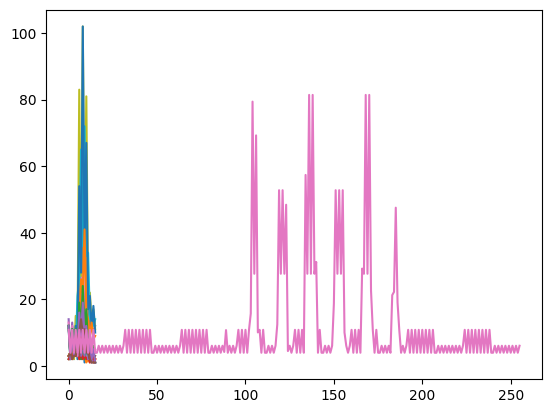

In [69]:
guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
plt.plot(realImg)
plt.plot(guess)
wsamps = np.random.multivariate_normal(res.x, res.hess_inv, 100)

for w in wsamps:
    tag_loc, intensity, background = [w[0], w[1]], [w[2], w[3], w[4]], [w[5], w[6], w[7]]
    guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
    plt.plot(guess, 'k-', alpha=0.1)

In [ ]:
# photoTags = getTags(raw15['0'], ['649'], 10)
# photo = getPhoto(photoTags[0])
# coords = [(tag.getX(), tag.getY()) for tag in photoTags]
# red, green, blue = zip(*(getPixels(tag.getSnipCoords(), photo) for tag in photoTags))
# red_bg, green_bg, blue_bg = getPixels((0, photo.shape[1]-1, 0, photo.shape[0]-1), photo)



In [ ]:
# cost_function(photo, coords, red, green, blue, red_bg, green_bg, blue_bg)
# scipy.optimize.minimize(cost_function, , args=(photo, coords, red, green, blue, red_bg, green_bg, blue_bg))
# scipy.optimize.minimize(cost_function, initial_parameters)

# calculate proportion of pixel in circle?

In [ ]:
# def perPixel(photo, colour):
#     fn(p, t, b, h, 5) - pixelColour(p, photo)